# Chapter 3: Object Tracking (Face Tracking)

## Part 2: Meanshift and Camshift.
Milica Novakovic
Osman Berk Satir

In this subsection, you will now use _meanshift_ and the _camshift_ algorithms for object tracking. The Meashift algorithm was originally presented as a clustering technique, which was then adapted for object tracking. On the other hand, the "Continuously  Adaptive  Meanshift"  algorithm (CamShift) is an extension of the Meanshift algorithm for object tracking in more general situations.

MeanShift is nothing but an algorithm for finding modes in a set of data samples representing an underlying probability density function (PDF) in $R^N$. It is a nonparametric clustering technique which does not require prior knowledge of the number of clusters and does not constrain the shape of the clusters.

In this section, you will use the OpenCV documentation to apply the aforementioned methods to a video file. Similar to the previous notebook you will use any high level (already implemented) function from OpenCV to complete the exercise specifications and outputs. The aim of this exercise is focused on __evaluating you capacity to search and understand basic image processing functions from OpenCV to complete the task__.


__Section Objectives:__

* Understand the use of the Meanshift and Camshift algorithm using OpenCV for face tracking.

* Apply them to video data and extract the results.

* Compare and evaluate the performance between them and a given ground truth

__Data__

For this assignment, you will use the data videos on ``../data/videos/`` labelled as "video_girl.avi". The ground truth (the solution or gold standard of the exercise) is included in the file: "video_girl_groundtruth_rect.txt". You will later use these results to compute the accuracy of your tracking. 


__Groundtruth__

The ground truth contains a list of four numbers per frame. Each line lists the __row, column, width and height__ of the face position.



## Meanshift 


Meanshift is a non-parametric feature-space analysis technique for locating the maxima of a density function, a so-called mode-seeking algorithm. It was originally presented in 1975 by Fukunaga and Hostetler paper, as a clustering algorithm. The mean shift algorithm can be used for visual tracking. The simplest such algorithm would create a confidence map in the new image based on the colour histogram of the object in the previous image and use Meanshift to find the peak of a confidence map near the object's old position. OpenCV provides a useful tutorial and example in its official documentation: 

https://docs.opencv.org/3.4.1/db/df8/tutorial_py_meanshift.html


As the first exercise, you will use the Meanshift function inside OpenCV to do face tracking. You will use your previously defined function (from the first assignment) to apply the Meanshift function over the first __50 frames__ of the video "video_girl.avi" and save the coordinates of the __region detected by the algoritmh__. As you can see (once you read the documentation and the example), mean-shift requires an initial mask region to perform the following tracking; you will use the first region listed in the ground truth file as an initial region.


Specifications: 

* The implemented solution should use the same function implemented in the first part.
* The output should contain a list of the rectangle region obtained from Meanshift over the first 50 frames.
* The function should receive as the parameter all the parameters needed to call the Meanshift function over the video.  This means that a user shouldn't need to modify the function internal code to test any set of parameters. 
* To corroborate your results, display the frame with the output rectangle region drawn in it, for the frames 1, 25 and 50.  



In [1]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
from utils import *
import matplotlib.pyplot as plt
import imutils
from imutils.object_detection import non_max_suppression
%matplotlib inline

In [2]:
def meanShiftFromVideoFile(file_path, function, params ):
    vidcap = cv2.VideoCapture(file_path)
    success = True
    final_output = []
    
    while success:
        success,image = vidcap.read()#Reading the images frame by frame
        
        if image is not None:
            output_handler = function(image,params)#Calling the process_frame_functions once for each frame.
    final_output = output_handler
    
    return final_output

In [3]:
def process_frame_function(image,params):
    count=0
    # Mean shift calls and steps
    # Region extraction
    region_list = params[2]
    if (len(region_list)==0):
        c,r,w,h = params[3]  # simply hardcoded the values
        track_window = (c,r,w,h) 
        params[8].append(track_window)
        # set up the ROI for tracking
        roi = image[r:r+h, c:c+w] #getting the face from the ground truth
        hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV) 
        COLOR_MIN = params[4]
        COLOR_MAX = params[5]
        mask = cv.inRange(hsv_roi, COLOR_MIN, COLOR_MAX)#obtaining the mask within a range.
        histsize=params[10]
        ranges=params[11]
        roi_hist = cv.calcHist([hsv_roi],[0],mask,histsize,ranges)
        cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
        params[9].append(roi_hist)
    iteration = params[6]
    pixel_distance = params[7]
    term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, iteration, pixel_distance)#Termination Criteria
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    roi_hist = params[9]
    roi_hist=np.array(roi_hist)
    rangesback=params[12]
    dst = cv.calcBackProject([hsv],[0],roi_hist[0],rangesback,1)
    track_window = params[8]
    if type(track_window) ==list:#At first track window is a list, then it comes as tuple so this if statement corrects that.
        track_window=track_window[0]
        region_list.append(track_window)#Appending the window to the windows before.
  
    _, track_window = cv.meanShift(dst, track_window, term_crit) #Getting the new window from old window and back projection of the histogram
    params[8] = track_window
    num_frames = params[1]
    #if (len(region_list)<num_frames):
    region_list.append(track_window)# old comment: Appending the window to the windows before if we have less than 50 frames
    
    return region_list# Output region for the first 50 frames.

file_path =  os.path.join('..','data', 'videos', 'video_girl.avi')
r,c,w,h = 57,21,31,45

#COLOR_MIN = np.array((0., 60.,32.))
#COLOR_MAX = np.array((180.,255.,255.))
COLOR_MIN = np.array([0, 10, 60], dtype = "uint8") 
COLOR_MAX = np.array([20, 150, 255], dtype = "uint8")
iteration = 10
pixel_distance = 1
hist_size=[16]
ranges=[0,180]
ranges_back=[0,180]

process_frame_params = []
#Params are what we needed to tune the parameters and store roi_hist and the first 50 windows. 
# params[0]
process_frame_params.append(file_path)

# params[1]
frames = 50
process_frame_params.append(frames)

# params[2]
process_frame_params.append([])

# params[3]
process_frame_params.append((r,c,w,h))

# params[4]
process_frame_params.append(COLOR_MIN)

# params[5]
process_frame_params.append(COLOR_MAX)

# params[6]
process_frame_params.append(iteration)

# params[7]
process_frame_params.append(pixel_distance)

# params[8]
process_frame_params.append([])

# params[9]
process_frame_params.append([])
#params[10]
process_frame_params.append(hist_size)
#params[11]
process_frame_params.append(ranges)
#params[12]
process_frame_params.append(ranges_back)
region_list = meanShiftFromVideoFile(file_path, process_frame_function, process_frame_params)

## Be sure to display the results below:

## Frame number
## Display image frame (1, 25, 50)
#Reading the video again to display the frames with our obtained windows.
vidcap = cv2.VideoCapture('../data/videos/video_girl.avi')
success,image = vidcap.read()
dim1=image.shape[0]
dim2=image.shape[1]
dim3=image.shape[2]
count = 1
success = True
#images_all= np.empty((image.shape))
images_all=image
#print(images_all)
while success:
    #cv2.imwrite("../data/videos/gym/frame%d.jpg" % count, image)  # save frame as JPEG file      
    success,image = vidcap.read()
    if image is not None:
        images_all=np.append(images_all,image)
        count += 1
images_all=np.reshape(images_all,(count,dim1,dim2,dim3))


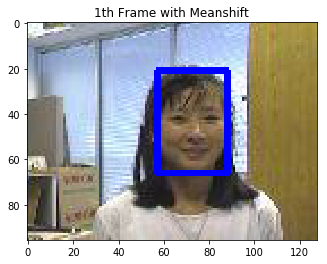

In [4]:
i=0#Displaying first frame
x,y,w,h = region_list[i]
img1 = cv.rectangle(images_all[i], (x,y), (x+w,y+h), 255,2)
display_image(img1)
plt.title("1th Frame with Meanshift")

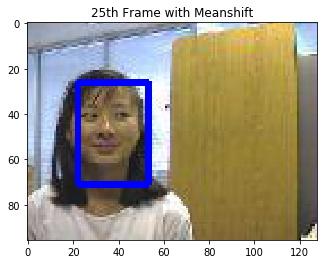

In [5]:
i=24#Displaying 25th frame
x,y,w,h = region_list[i]
img2 = cv.rectangle(images_all[i], (x,y), (x+w,y+h), 255,2)
display_image(img2)
plt.title("25th Frame with Meanshift")

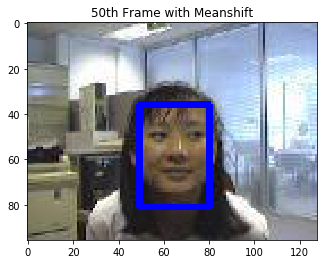

In [6]:
i=49 #Displaying 50th frame
x,y,w,h = region_list[i]
img3 = cv.rectangle(images_all[i], (x,y), (x+w,y+h), 255,2)
display_image(img3)
plt.title("50th Frame with Meanshift")

### Hints 

* As mentioned before, this exercise will evaluate your capacity to understand and adapt the example code from the aforementioned tutorial to solve the exercise. However, feel free to search and use any other example/code that you may find.
* Be sure to understand each line from the suggested example. Some parts you should pay attention to are:
  * What are the hardcoded values given to the functions: inRange, calcHist and calcBackProject? 
  * Are those the best values for my input? 
  * How does the mask looks like? 
* Notice that the ground truth contains the row, column, width, height. In the example, they have different input order.
* Finally, notice that in this tutorial they use the HSV colour space, specifically the first channel. Why is this? 



## Camshift

Continuously adaptive mean-shift(CAMShift) was proposed as an efficient and light-weight tracking algorithm developed based on mean-shift. What Camshift do is nothing but do meanShift in every single frame of a video, and adapt the parameters and the window using (a very basic) backpropagation. With this simple idea, however, Camshift is able to track objects in multiscale situations. On the other hand, it makes Camshift much more sensible to lightning changes or obfuscation problems. 


As a second exercise, you will test the Camshift algorithm from OpenCV following the same specifications to the same first __50 initial frames__. You can use a different set of parameters to test, the main shift and make it work.



In [7]:
def process_frame_function(image,params):
    count=0
    # Mean shift calls and steps
    # Region extraction
    region_list = params[2]
    if (len(region_list)==0):
        c,r,w,h = params[3]  # simply hardcoded the values
        track_window = (c,r,w,h) 
        params[8].append(track_window)
        # set up the ROI for tracking
        roi = image[r:r+h, c:c+w] #getting the face from the ground truth
        hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV) 
        COLOR_MIN = params[4]
        COLOR_MAX = params[5]
        mask = cv.inRange(hsv_roi, COLOR_MIN, COLOR_MAX)#obtaining the mask within a range.
        histsize=params[10]
        ranges=params[11]
        roi_hist = cv.calcHist([hsv_roi],[0],mask,histsize,ranges)#calculating histogram of roi
        cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)#normalizing the histogram
        params[9].append(roi_hist)
    iteration = params[6]
    pixel_distance = params[7]
    term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, iteration, pixel_distance)#Termination Criteria
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    roi_hist = params[9]
    roi_hist=np.array(roi_hist)
    rangesback=params[12]
    dst = cv.calcBackProject([hsv],[0],roi_hist[0],rangesback,1)#Calculating the back projection of the histogram.
    track_window = params[8]
    if type(track_window) ==list:#At first track window is a list, then it comes as tuple so this if statement corrects that.
        track_window=track_window[0]
        region_list.append(track_window)#Appending the window to the windows before.
  
    _, track_window = cv.CamShift(dst, track_window, term_crit) #Getting the new window from old window and back projection of the histogram
    #with camshift
    params[8] = track_window
    num_frames = params[1]
    #if (len(region_list)<num_frames):
    region_list.append(track_window) #Old comment: Appending the window to the windows before if we have less than 50 frames
    
    return region_list# Output region for the first 50 frames.

file_path =  os.path.join('..','data', 'videos', 'video_girl.avi')
r,c,w,h = 57,21,31,45

#COLOR_MIN = np.array((0., 60.,32.))
#COLOR_MAX = np.array((180.,255.,255.))
COLOR_MIN = np.array([0, 10, 60], dtype = "uint8") 
COLOR_MAX = np.array([20, 150, 255], dtype = "uint8")
iteration = 10
pixel_distance = 1
hist_size=[180]
ranges=[0,180]
ranges_back=[0,180]

process_frame_params = []
#Params are what we needed to tune the parameters and store roi_hist and the first 50 windows. 
# params[0]
process_frame_params.append(file_path)

# params[1]
frames = 50
process_frame_params.append(frames)

# params[2]
process_frame_params.append([])

# params[3]
process_frame_params.append((r,c,w,h))

# params[4]
process_frame_params.append(COLOR_MIN)

# params[5]
process_frame_params.append(COLOR_MAX)

# params[6]
process_frame_params.append(iteration)

# params[7]
process_frame_params.append(pixel_distance)

# params[8]
process_frame_params.append([])

# params[9]
process_frame_params.append([])
#params[10]
process_frame_params.append(hist_size)
#params[11]
process_frame_params.append(ranges)
#params[12]
process_frame_params.append(ranges_back)
region_list_camshift = meanShiftFromVideoFile(file_path, process_frame_function, process_frame_params)

## Be sure to display the results below:

## Frame number
## Display image frame (1, 25, 50)
#Reading the video again to display the frames with our obtained windows.
vidcap = cv2.VideoCapture('../data/videos/video_girl.avi')
success,image = vidcap.read()
dim1=image.shape[0]
dim2=image.shape[1]
dim3=image.shape[2]
count = 1
success = True
#images_all= np.empty((image.shape))
images_all=image
#print(images_all)
while success:
    #cv2.imwrite("../data/videos/gym/frame%d.jpg" % count, image)  # save frame as JPEG file      
    success,image = vidcap.read()
    if image is not None:
        images_all=np.append(images_all,image)
        count += 1
images_all=np.reshape(images_all,(count,dim1,dim2,dim3))

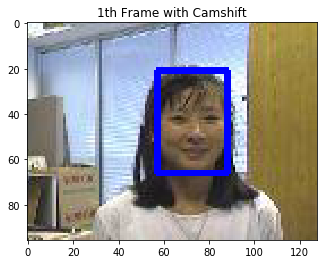

In [8]:
i=0#Displaying first frame
x,y,w,h = region_list_camshift[i]
img1 = cv.rectangle(images_all[i], (x,y), (x+w,y+h), 255,2)
display_image(img1)
plt.title("1th Frame with Camshift")

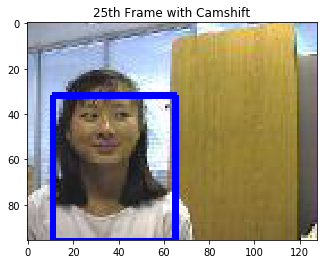

In [9]:
i=24#Displaying first frame
x,y,w,h = region_list_camshift[i]
img2 = cv.rectangle(images_all[i], (x,y), (x+w,y+h), 255,2)
display_image(img2)
plt.title("25th Frame with Camshift")

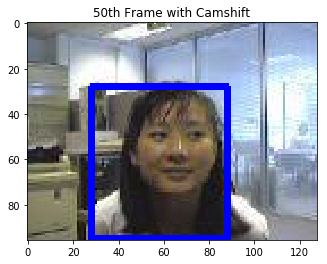

In [10]:
i=49#Displaying first frame
x,y,w,h = region_list_camshift[i]
img3 = cv.rectangle(images_all[i], (x,y), (x+w,y+h), 255,2)
display_image(img3)
plt.title("50th Frame with Camshift")

# Comparision metrics

For the last part of the assignment, you are asked to compare the performance of the Camshift tracker and the Meanshift tracker, frame wise, in terms of average Intersection over Union (IoU) of the object ground truth bounding boxes during the first __50 frames__; which is basically the ratio between the area of the intersection over the union.

You can find the metric as the Jaccard index https://en.wikipedia.org/wiki/Jaccard_index. Feel free to modify the implementation below to adapt it to your function output.



In [11]:
def IoU(boxA, boxB):
    
    '''
    Inputs: 
        boxA: top left and bottom right coordinates of the first bunding Box
        boxB: top left and bottom right coordinates of the second bunding Box

    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou



IoU([39, 63, 203, 112],[40, 63, 205, 112])

0.9820359281437125

In [12]:
import numpy as np
box1=np.zeros((50,4))#the box for ground truth
box2=np.zeros((50,4))#the box from meanshift
box3=np.zeros((50,4))#the box from camshift
file_object  = np.loadtxt(r'C:\Users\novak\OneDrive\Documents\EPFL\CS-451 Image Analysis and Pattern recognition\ip_lab_2018\data\videos\video_girl_groundtruth_rect.txt.txt')#'/home/obsatir/ip_lab_2018/data/videos/video_girl_groundtruth_rect.txt') 
for i in range(50):
    box1[i][0]=file_object[i][0]
    box1[i][1]=file_object[i][1]
    box1[i][2]=file_object[i][0]+file_object[i][2]    
    box1[i][3]=file_object[i][1]+file_object[i][3] 


for i in range(50):
    box2[i][0]=region_list[i][0]
    box2[i][1]=region_list[i][1]
    box2[i][2]=region_list[i][0]+region_list[i][2]    
    box2[i][3]=region_list[i][1]+region_list[i][3] 
    
for i in range(50):
    box3[i][0]=region_list_camshift[i][0]
    box3[i][1]=region_list_camshift[i][1]
    box3[i][2]=region_list_camshift[i][0]+region_list_camshift[i][2]    
    box3[i][3]=region_list_camshift[i][1]+region_list_camshift[i][3] 

IoUmean=[]
IoUcam=[]
for i in range(50):
    IoUmean.append(IoU(box1[i],box2[i]))
    IoUcam.append(IoU(box1[i],box3[i]))

print("The mean IoU with Meanshift= ",np.mean(IoUmean[1:49]))
print("The mean IoU with Camshift= ",np.mean(IoUcam[1:49]))
print("The max IoU with Meanshift= ",np.max(IoUmean[1:49]))#Here we didnt include the first frame since it was 1 as we got it from ground truth.
print("The max IoU with Camshift= ",np.max(IoUcam[1:49]))
print("The min IoU with Meanshift= ",np.min(IoUmean[1:49]))
print("The min IoU with Camshift= ",np.min(IoUcam[1:49]))
bestmean=np.argmax(IoUmean[1:49])
bestcam=np.argmax(IoUcam[1:49])
worstmean=np.argmin(IoUmean[1:49])
worstcam=np.argmin(IoUcam[1:49])

bestmeantotal=np.argmax(IoUmean)
bestcamtotal=np.argmax(IoUcam)
worstmeantotal=np.argmin(IoUmean)
worstcamtotal=np.argmin(IoUcam)

The mean IoU with Meanshift=  0.704328781712
The mean IoU with Camshift=  0.381564174483
The max IoU with Meanshift=  0.910327767471
The max IoU with Camshift=  0.761904761905
The min IoU with Meanshift=  0.40485629336
The min IoU with Camshift=  0.232472324723


Report the following quantities: 

* The Min, Mean and Max IoU between the Meanshift and the ground truth (first 50 frames).
* The Min, Mean and Max IoU between the Camshift and the ground truth (first 50 frames).
* Display the BEST (min IoU) and the worst (max IoU) for both algorithms.

__REMARKS:__ If any of the two algorithms is disastrously failing you need to go back and tune the parameters. If the tracking is unsuccessful due to an inappropriate adaptation/implementation of the algorithms, no points will be given.


Write a small report summarizing the election of the selected parameters. Mention any important remark over the performance, especially indicating why it is failing in some cases (unless you have a perfect IoU). 

Finally, make a **quantitative** comparison of the performance of both methods. Include and display any frame where you consider that the difference between both methods manifests.



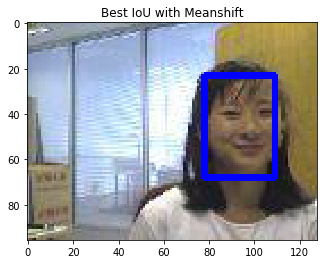

In [13]:
x,y,w,h = region_list[bestmean]
img1 = cv.rectangle(images_all[bestmean], (x,y), (x+w,y+h), 255,2)
display_image(img1)
plt.title("Best IoU with Meanshift")

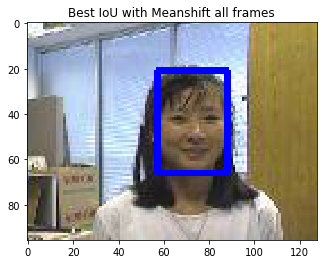

In [14]:
x,y,w,h = region_list[bestmeantotal]
img1 = cv.rectangle(images_all[bestmeantotal], (x,y), (x+w,y+h), 255,2)
display_image(img1)
plt.title("Best IoU with Meanshift all frames")

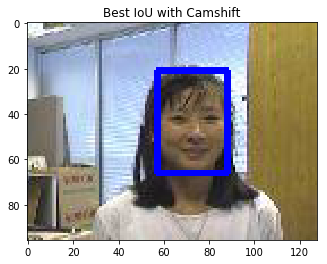

In [15]:
x,y,w,h = region_list_camshift[bestcam]
img2 = cv.rectangle(images_all[bestcam], (x,y), (x+w,y+h), 255,2)
display_image(img2)
plt.title("Best IoU with Camshift")

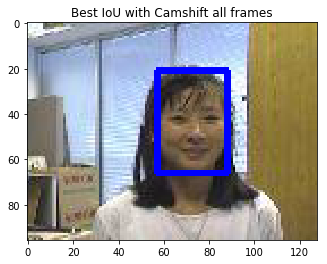

In [16]:
x,y,w,h = region_list_camshift[bestcamtotal]
img2 = cv.rectangle(images_all[bestcamtotal], (x,y), (x+w,y+h), 255,2)
display_image(img2)
plt.title("Best IoU with Camshift all frames")

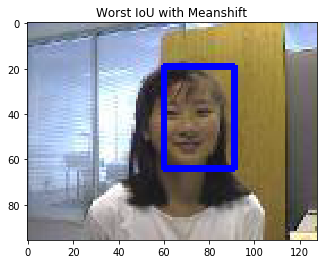

In [17]:
x,y,w,h = region_list[worstmean]
img3 = cv.rectangle(images_all[worstmean], (x,y), (x+w,y+h), 255,2)
display_image(img3)
plt.title("Worst IoU with Meanshift")

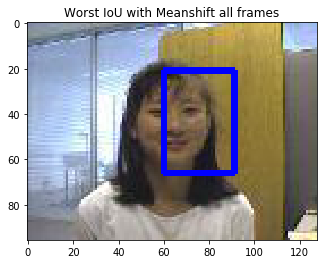

In [18]:
x,y,w,h = region_list[worstmeantotal]
img3 = cv.rectangle(images_all[worstmeantotal], (x,y), (x+w,y+h), 255,2)
display_image(img3)
plt.title("Worst IoU with Meanshift all frames")

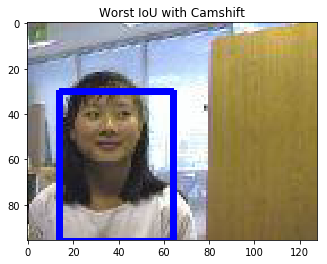

In [19]:
x,y,w,h = region_list_camshift[worstcam]
img4 = cv.rectangle(images_all[worstcam], (x,y), (x+w,y+h), 255,2)
display_image(img4)
plt.title("Worst IoU with Camshift")

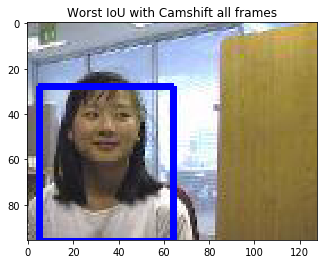

In [20]:
x,y,w,h = region_list_camshift[worstcamtotal]
img4 = cv.rectangle(images_all[worstcamtotal], (x,y), (x+w,y+h), 255,2)
display_image(img4)
plt.title("Worst IoU with Camshift all frames")

In this part, we tried to detect a moving person in a video by using meanshift and camshift. The important parts were tuning up the parameters, such as histogram size and the color range of the mask. We tried a lot of different parameters for those parameters and for color range, we decided to use between (0,10,60) and (20,150,255), when we calculate the histogram, since the pixels between these values are similar to the color of the skin, thus they are the important ones. For histogram size, 16 gave a better result for meanshift when we did a parameter sweep and 180 gave a better result for camshift. For the other parameters, we tried to tune them aswell but they did not affect the results as much as these two parameters did.

For quantitative assessment, it is possible to say that meanshift does a better result than camshift, since max, mean  and min values are higher for meanshift. Below it is possible to see a frame where meanshift definitely better than camshift.

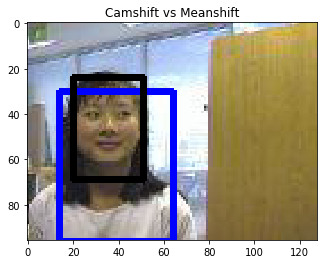

In [21]:
x,y,w,h = region_list[worstcam]
img4 = cv.rectangle(images_all[worstcam], (x,y), (x+w,y+h), 0,2)
display_image(img4)
plt.title("Camshift vs Meanshift")

Above, the black rectangle is from meanshift and the blue one is from camshift. This frame is where camshift's IoU is the worst, and it is possible to see that the output window of camshift is way bigger than meanshift. This applies for most of the frames, and the biggest reason that camshift's mean IoU is low.

Even with the fact that Camshift has to wide boundary, it captures the face so it does tracking, but not in very precise manner.  We can see that on the first fifthy frames even if there is shadows on her face, but not generaly different lighting condition, the algorithms does not have challanging conditions such as lighting or obfurscation, and therefore perform very well. During the whole video, the worst Meanshift performance can be understood by obfurscation (door has the almost the same color as her face, and remember that this algorithms depend by H value, so this is very challenging frame for so these simple algorithms). By looking at the worst frame for Camshift, it looks like this algorithm does not have same problem as Meanshift, but we shoud take into account that the hist size is not the same. It seems that low IoU value is influenced not by lighting, but rather by the fact that the IoU is large due to not accurate boundaries of Camshift